In [1]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
from scipy.optimize import fmin

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist_cutoff
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM, get_stats_EAM_pairdist
from statmechlib.forcefields import sd2_loss, utot_EAM, ftot_EAM, udif_print, u_core
from statmechlib.preprocessing import universal_eos

In [4]:
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

In [21]:
n = int((1.45-0.85)/0.05 + 0.01)
reos = np.linspace(0.85, 1.45, n+1)*2.74
#for i, scale in enumerate(np.linspace(0.85, 1.45, 13)):
#    print(round(reos[i], 3), universal_eos(scale, 'W'))

In [6]:
with open(os.path.join(working, 'stats_ready'+'.pickle'), 'rb') as fi:
    stats_ready = pickle.load(fi)

with open(os.path.join(working, 'target_ready'+'.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [7]:
print(stats_ready['hyperparams'])

[2.5, 2.65, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.356, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75]


In [8]:
multi_index = []
multi_index.append([0, 2, 3, 5, 7, 10, 12, 15])
multi_index.append([0, 2, 4, 6, 8, 10, 12, 14])
multi_index.append([0, 2, 4, 6, 8, 11, 13, 15])
multi_index.append([1, 2, 3, 5, 7, 10, 12, 14])
multi_index.append([1, 2, 4, 6, 8, 11, 13, 15])
multi_index.append([1, 2, 4, 6, 9, 11, 13, 15])
multi_index.append([1, 3, 5, 7, 9, 11, 13, 15])

In [9]:
stats_opts = []
for index in multi_index:
    index = np.array([True if i in index else False for i in range(len(stats_ready['hyperparams']))])
    print(np.array(stats_ready['hyperparams'])[index])
    stats_opts.append(select_nodes(stats_ready, index))

[2.5  2.75 3.   3.5  4.   4.5  5.   5.75]
[2.5  2.75 3.25 3.75 4.25 4.5  5.   5.5 ]
[2.5  2.75 3.25 3.75 4.25 4.75 5.25 5.75]
[2.65 2.75 3.   3.5  4.   4.5  5.   5.5 ]
[2.65 2.75 3.25 3.75 4.25 4.75 5.25 5.75]
[2.65  2.75  3.25  3.75  4.356 4.75  5.25  5.75 ]
[2.65  3.    3.5   4.    4.356 4.75  5.25  5.75 ]


In [10]:
#with open(os.path.join(working, "stats_multi.pickle"), 'wb') as fo:
#    pickle.dump(stats_opts, fo)

In [11]:
#with open(os.path.join(working, "target_multi.pickle"), 'wb') as fo:
#    pickle.dump(targ_ready, fo)

In [12]:
# read corresponding parameters
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_dict = pickle.load(fi)

pars_in = pars_dict['embed'] + pars_dict['pair']
print(pars_in)

[-0.344540412587315, 1.6869558429105695e-05, 0.4527535290774057, 7.091857873610367, 1.6314949612839302, 0.7906877956550405, -0.8249673243680319, 0.14501087706040938, -0.002061634677032549, 0.0021894588902290147]


In [13]:
with open(os.path.join(working, 'stats_multi.pickle'), 'rb') as fi:
    stats_opts = pickle.load(fi)

with open(os.path.join(working, 'target_multi.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [14]:
it = 2 # read in it (independent process)
stats = []
target = []
for key in list(targ_ready.keys()):
    stats.append(stats_opts[it][key])
    target.append(targ_ready[key])

In [15]:
def optimize_EAM(target, stats, ieam, multi_pars, n_b=2):
    
    optimal_parameters = []
    
    for i, pars in enumerate(multi_pars):
        sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [ieam])
        print(i,' sd2: ini', sd_ini, end='')
        output = fmin(sd2_loss, pars, args=(stats, target, utot_EAM, None, [ieam]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
        optimal_parameters.append(tuple([output[1], output[0]]))
        print('sd2: final', output[1])

    n_best = min(n_b, len(optimal_parameters))
                 
    best_params = sorted(optimal_parameters)[:n_best]
    
    print('Best params:', best_params)

    return best_params

In [16]:
multi_pars = []
multi_pars.append(pars_in)
for _ in range(4):
    pars = np.array(pars_in)
    pars += np.random.standard_normal(pars.shape)*0.07
    print(pars)
    multi_pars.append(pars)

[-0.4141044  -0.03951211  0.49088958  7.1488957   1.67706284  0.71038753
 -0.84090038  0.03646109 -0.0354178   0.12260251]
[-3.80892060e-01  3.03555398e-03  5.46238137e-01  7.06723151e+00
  1.74922040e+00  7.54957894e-01 -8.34986204e-01  1.96997165e-01
  1.13314513e-01  6.68271643e-03]
[-3.16451584e-01  4.66238420e-03  3.89279204e-01  7.13790474e+00
  1.70691420e+00  8.43165438e-01 -7.98565738e-01  2.31543002e-01
  4.08409293e-02  1.82000263e-02]
[-0.32490021 -0.03578817  0.39090867  7.1678345   1.70147744  0.84543367
 -0.8272709   0.20010768 -0.07965459  0.07769506]


In [17]:
for ieam in range(4, len(stats_opts[it]['hyperparams'])):
    print('ieam:', ieam)
    for i in range(6):
        best_pars = optimize_EAM(target, stats, ieam, multi_pars)
        multi_pars = [p[1] for p in best_pars]

ieam: 4
0  sd2: ini 12.748006702327558sd2: final 0.01016972076295386
1  sd2: ini 19.71782631212136sd2: final 0.006215326210446043
2  sd2: ini 21.277980590071614sd2: final 0.002304118969732464
3  sd2: ini 21.24943489646291sd2: final 0.0013801301877890391
4  sd2: ini 19.293967769876947sd2: final 0.002404935422724283
Best params: [(0.0013801301877890391, array([ 1.16509820e-01,  1.90431940e-03, -1.77121531e+00,  8.18721008e+00,
       -1.80741773e+00,  3.85543943e+00, -3.19491008e+00,  1.86833616e+00,
       -4.92495627e-01, -5.86957882e-02])), (0.002304118969732464, array([ 4.76437691e-01,  2.61726017e-03, -4.79598247e+00,  2.58910642e+00,
        9.53905299e-02,  2.32009500e+00, -2.78794500e+00,  2.29476313e+00,
       -1.02733819e+00,  9.52627447e-02]))]
0  sd2: ini 0.0013801301877890391sd2: final 0.00021277027512724194
1  sd2: ini 0.002304118969732464sd2: final 0.0003582040423541045
Best params: [(0.00021277027512724194, array([-1.41820012e+00,  9.85319393e-04,  7.22226563e+01,  5.981

0  sd2: ini 0.00014587955861265154sd2: final 0.00013598010732754137
1  sd2: ini 0.0002291349071043658sd2: final 0.00022819478861719003
Best params: [(0.00013598010732754137, array([-5.66570226e-01,  7.63308312e-05,  1.72633428e+01,  1.25722291e+01,
       -3.89309933e+00,  4.82330223e+00, -2.92638465e+00,  8.12711142e-01,
        1.07014368e-01, -1.09663816e-01])), (0.00022819478861719003, array([-1.48103630e-01,  1.47038896e-04,  1.04944103e+02, -1.91388066e+00,
       -2.57858541e+00,  4.96557990e+00, -3.98158721e+00,  1.88333164e+00,
       -3.38988238e-01, -9.29454552e-02]))]
0  sd2: ini 0.00013598010732754137sd2: final 0.00012806275781989296
1  sd2: ini 0.00022819478861719003sd2: final 0.00022571630986968424
Best params: [(0.00012806275781989296, array([-6.39414579e-01,  6.61908631e-05,  1.90688614e+01,  1.32127835e+01,
       -3.33852259e+00,  4.34658398e+00, -2.73850133e+00,  8.82357849e-01,
       -2.38155880e-02, -5.77138789e-02])), (0.00022571630986968424, array([-1.71317295e

In [88]:
multi_pars

[array([-2.46692536e+00, -7.07645876e-04, -1.92990197e+02,  5.43710332e+01,
        -1.17019464e+01,  1.26314518e+00,  3.72747439e+00, -4.17045991e+00,
         2.46942853e+00, -4.39168938e-01]),
 array([-1.39247738e+00,  1.45832318e-03, -1.22829256e+02,  3.89427039e+01,
        -7.01985954e+00, -4.45624270e-01,  3.84825703e+00, -3.54791628e+00,
         1.89469535e+00, -3.48857885e-01])]

In [18]:
optimal_parameters = [(0.00012006919081731452, [-4.44842384e-01,  2.21455097e-05,  3.33963127e+01,  1.20965190e+01,
       -2.63981811e+00,  3.42637287e+00, -2.01448436e+00,  6.88574994e-01,
       -2.00181569e-01,  3.08184020e-02])]

5
Targ: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498]
Model: [-1138.7468642450626, -907.0057314831845, -1127.4685021129915, -1137.0727469492165, -1136.0732989780167]
[0.0390625  0.0462963  0.03937008 0.03875969 0.03875969]
0 0.00012006919081731452


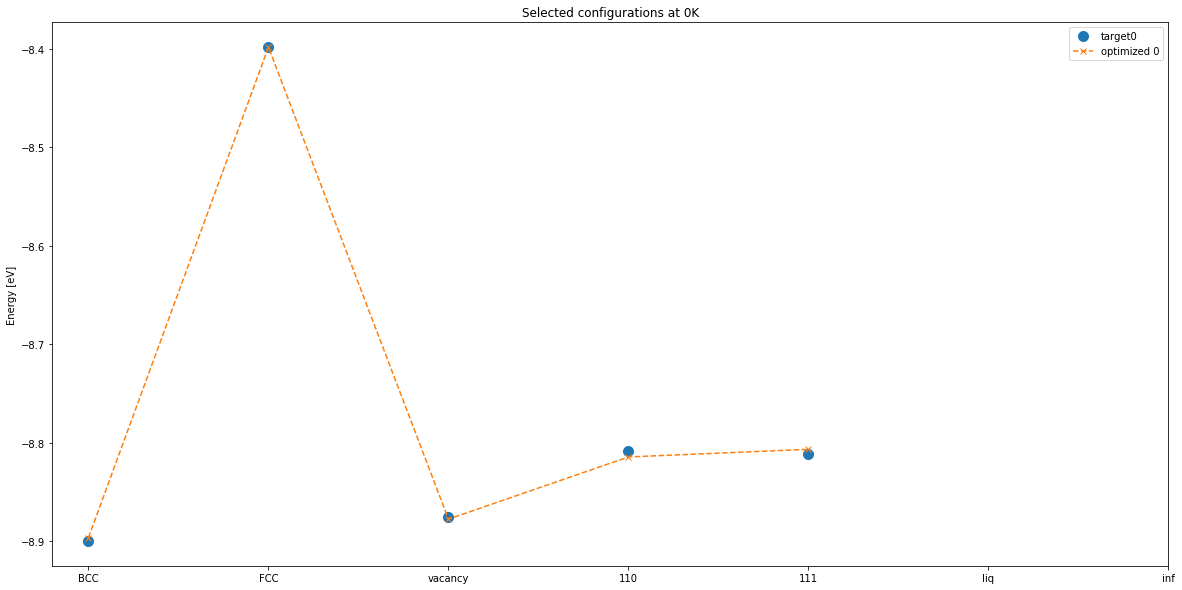

In [24]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['relax']['xyz']])[:-2]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [7])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-2][:-2])
        print('Model:', opti_out[-2][:-2])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-2][:-2]))/nat)
        plt.plot(np.array(targ_out[-2][:-2])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-2][:-2]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

13
Targ: [-271.8047221070888, -837.1711089986524, -1079.5267350307165, -1139.2, -1100.8887858645915, -1014.6561261471663, -909.2807161131147, -800.6633444635341, -697.0611202328876, -602.3043063713144, -517.7429994565125, -443.4032853774631, -378.657941519064]
Model: [-272.9259128164474, -834.7322327139491, -1081.8052966888795, -1138.7468642450626, -1097.0395644018768, -1014.5119358659786, -914.699514699419, -807.3575845785504, -701.0378021630931, -601.0910945413891, -511.3597181674677, -439.3543436810054, -385.56672675354986]
[0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625
 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625]
0 0.00012006919081731452


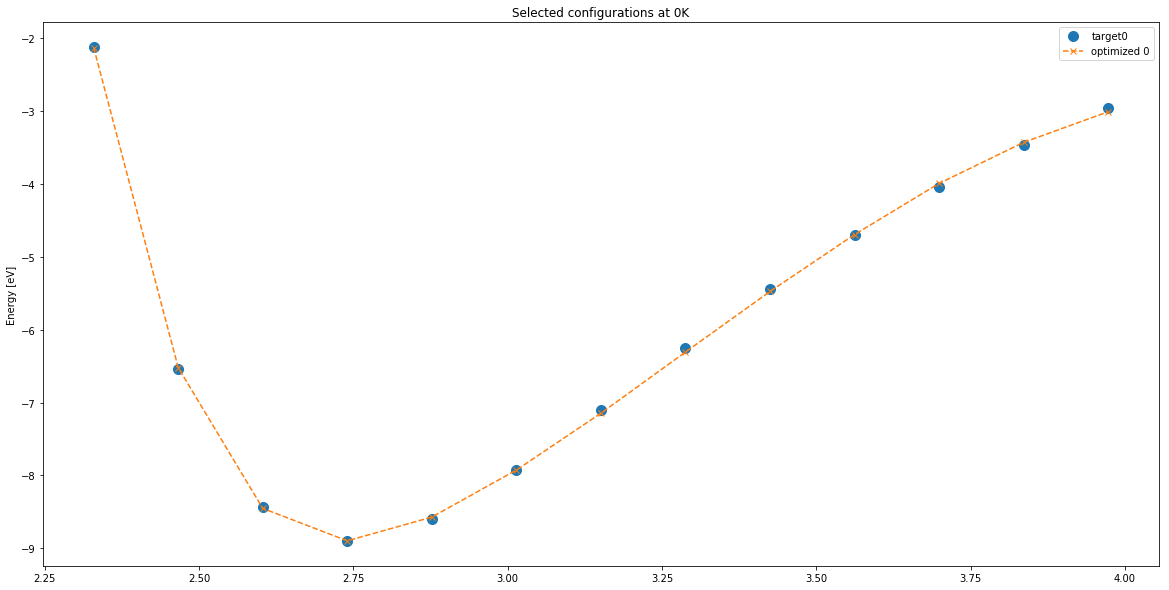

In [23]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos']['xyz']])[1:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [7])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-1][1:])
        print('Model:', opti_out[-1][1:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-1][1:]))/nat)
        plt.plot(reos, np.array(targ_out[-1][1:])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(reos, np.array([o for o in opti_out[-1][1:]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

1138
[8.890625 8.890625 8.890625 ... 8.890625 8.890625 8.890625]
0 0.00012006919081731452


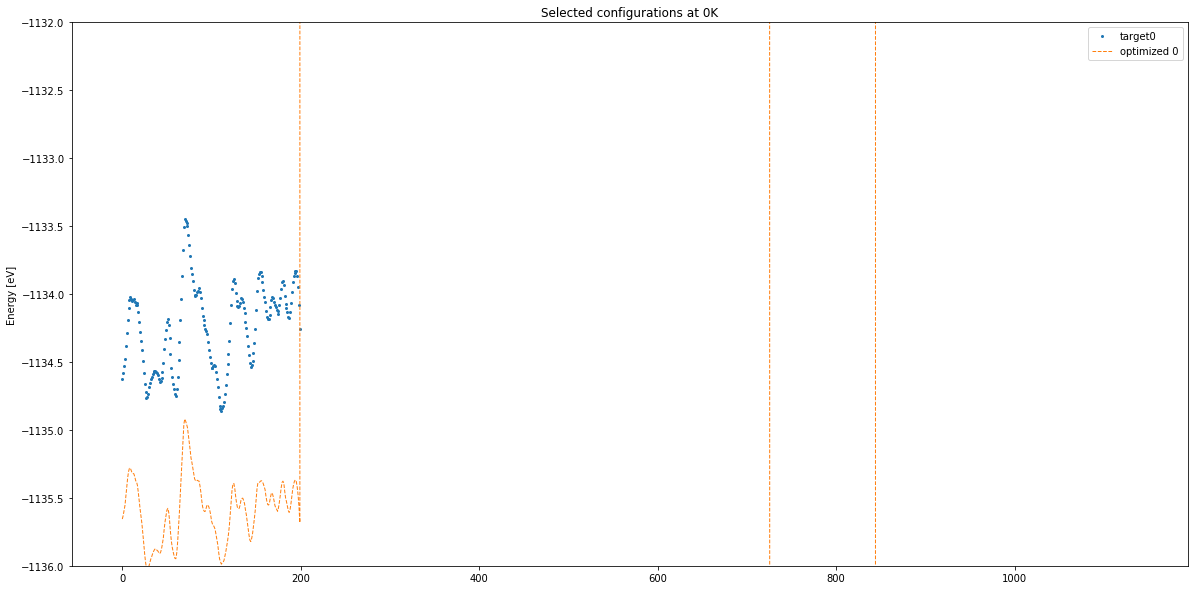

In [25]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM,[7])
    plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=2)

        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), '--', label='optimized '+str(i), lw=1.0)

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

plt.ylim(-1180,-700)
plt.ylim(-1136,-1132)
#plt.ylim(-1000,-900)

plt.legend()

In [121]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0] > 1.1e-3:
        continue
    print(i, params_uopt[0], '\n', params_uopt[1])

0 0.00012508417047382345 
 [-0.942576521, 7.61707891e-05, -105.811358, 36.1001559, -6.39102078, -0.0242484404, 2.91284708, -2.96955528, 1.3606181, -0.17478259]


In [126]:
stats_opt['hyperparams']

[2.65, 3.0, 3.5, 4.0, 4.356, 4.75, 5.25, 5.75]

In [127]:
stats_opts[it]['hyperparams']

[2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.75]

In [128]:
pars_out = {}
pars_out['pair_nodes'] = stats_opts[it]['hyperparams']
pars_out['mb_node'] = 6
pars_out['params'] = [optimal_parameters[0]]

In [129]:
optimal_list = []

#with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
#    optimal_list = pickle.load(fi)

#if type(optimal_list) != list:
#    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo)

In [130]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [131]:
optimal_list

[{'pair_nodes': [2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.75],
  'mb_node': 6,
  'params': [(0.00012508417047382345,
    [-0.942576521,
     7.61707891e-05,
     -105.811358,
     36.1001559,
     -6.39102078,
     -0.0242484404,
     2.91284708,
     -2.96955528,
     1.3606181,
     -0.17478259])]}]

In [151]:
# Total pair potential
pos = targ_ready['relax']['xyz'][0]
bx = targ_ready['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [152]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [153]:
optimal_list[-1]['params'][0][1]

[-0.942576521,
 7.61707891e-05,
 -105.811358,
 36.1001559,
 -6.39102078,
 -0.0242484404,
 2.91284708,
 -2.96955528,
 1.3606181,
 -0.17478259]

In [154]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [155]:
pair_y, many_y, V_x_r, rho_x_r

([-105.811358,
  36.1001559,
  -6.39102078,
  -0.0242484404,
  2.91284708,
  -2.96955528,
  1.3606181,
  -0.17478259],
 [-0.942576521, 0.0, 7.61707891e-05],
 [2.5, 2.75, 3.0, 3.5, 4.0, 4.5, 5.0, 5.75],
 [5.0])

In [156]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)

Text(0,0.5,'U')

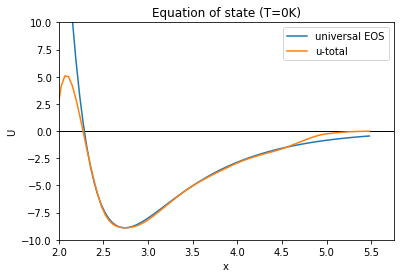

In [157]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.ylim(-10,10)

plt.xlabel('x')
plt.ylabel(r'U')

In [39]:
rho_a = [1.0]
rho_r = [stats_opt['hyperparams'][-1]]

pair_a = pars_in1[2:]
pair_r = stats_opt['hyperparams']

many_a = [pars_in[0], 0.0, pars_in[1]]

In [40]:
# Ranges of densities and separations

nr = 5000
rcut = stats_opt['hyperparams'][-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
#rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

rhomax: 768.0


In [41]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [42]:

# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [708]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lvnew.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))